In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os, sys
from pathlib import Path
from pandarallel import pandarallel
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

########   Initialize and setup pandas methods   ########
pandarallel.initialize(nb_workers=os.cpu_count()-1, progress_bar=False, 
                       verbose=2, use_memory_fs=False) 
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../'))

from libs.scoring import Scoring

import warnings
warnings.simplefilter('ignore')

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### FUNCTIONS

In [3]:
def specificity_sensitivity_plotly(data):
    thresholds = np.arange(0, 11, 1)
    results = []

    for threshold in thresholds:
        tp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0
        # print(f"Threshold: {threshold}, TP: {tp}, FN: {fn}, TN: {tn}, FP: {fp}")
        # print(f"Threshold: {threshold}, Specificity: {specificity:.6f}, Sensitivity: {sensitivity:.6f}")
        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    results_df = pd.DataFrame(results)
    return results_df

def plot_sensitivity_specificity_plotly(
        results_df: pd.DataFrame, w: int, h: int):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='#665990'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.3f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text'
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='#F8ACAC'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.3f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text'
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=w, height=h)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig

def plot_sensitivity_specificity_plotly_without_legened(results_df):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='green'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.8f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text',
        showlegend=False 
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='orange'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.8f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text',
        showlegend=False
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=600, height=600)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig


# Code below is adapted from Netflix's VMAF and BesenbacherLab's ROC-utils
# https://github.com/Netflix/vmaf/
# https://github.com/BesenbacherLab/ROC-utils
# Modifications: np.float -> np.float64

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

# Calculate AUC confidence interval (95%)
def compute_auc_confidence_interval(auc, var, confidence_level=0.95):
    alpha = 1 - confidence_level
    z_score = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z score
    se = np.sqrt(var)  # Calculate SE from variance
    lower_bound = auc - z_score * se
    upper_bound = auc + z_score * se
    return lower_bound, upper_bound


def scoaring_calibraiton(ths: dict, tn_pkl: str, tp_pkl: str):

    ths_scores = {'clinvar_same_pos': ths['s1'],
             'clinvar_same_motif': ths['s2'],
             'clinvar_else': ths['s3'],
             'non_canon_splai_lte_0.1_outside': ths['s4'],    
             'non_canon_splai_lte_0.1_other': ths['s5'],
             'non_canon_splai_bet_0.1_0.2': ths['s6'],
             'non_canon_splai_gte_0.2': ths['s7'],
             'canon_strong': ths['s8'], 
             'canon_moderate': ths['s9'], 
             'frameshift_nmd_eloF': ths['s10'], 
             'frameshift_nmd_not_eloF': ths['s11'],
             'canon_splai_lte_0.1': ths['s12'],
             'canon_splai_bet_0.1_0.2': ths['s13'],
             'canon_splai_gte_0.2': ths['s14']}

    scoring = Scoring(ths=ths_scores)
    df = pd.read_pickle('../TP/tp_prescore_train.pkl')
    df = pd.read_pickle(tn_pkl)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tp = scoring.calc_priority_score(df)

    df = pd.read_pickle('../TN/tn_prescore_train.pkl')
    df = pd.read_pickle(tp_pkl)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tn = scoring.calc_priority_score(df)

    # Exclude Y chromosome
    tn = tn[tn['CHROM'] != 'Y']
    # print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

    tp.loc[:,'LABEL'] = 1
    tn.loc[:,'LABEL'] = 0
    tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

    # Combine tp and tn
    data = pd.concat([tp, tn], ignore_index=True)
    results_df = specificity_sensitivity_plotly(data)
    # plot_sensitivity_specificity_plotly(results_df)

    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    # predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
    # auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    # cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

    # p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

    # print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    # print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    # print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

    return f"{auc1:.10f} [{cilower1:.12f}-{ciupper1:.12f}]"


In [3]:
from ortools.sat.python import cp_model

class SolutionCollector(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solutions = []

    def OnSolutionCallback(self):
        solution = {v.Name(): self.Value(v) for v in self.__variables}
        self.__solutions.append(solution)

    def GetAllSolutions(self):
        return self.__solutions

def find_all_solutions():
    # モデルを初期化
    model = cp_model.CpModel()

    # 変数の定義
    s = {i: model.NewIntVar(-10, 10, f's{i}') for i in range(1, 15)}

    # 制約の追加
    model.Add(s[3] == 0)                    #
    model.Add(s[1] + s[10] + s[14] == 9)    #
    model.Add(s[3] + s[11] + s[12] == 0)    #
    # model.Add(s[1] + s[7] < 9)
    # model.Add(s[10] >= 3)
    # model.Add(s[10] <= 7)
    
    # Knowledge-based
    # Absolutes
    model.Add(s[2] >= 1)                #
    model.Add(s[1] - s[2] > 0)          #   
    
    # SpliceAI limitation
    # Absolutes
    model.Add(s[4] < 0)                 #
    model.Add(s[5] <= 0)                #
    model.Add(s[6] >= 0)                #
    # model.Add(s[7] >= 1)
    model.Add(s[12] < 0)                #
    model.Add(s[13] <= 0)               #
    model.Add(s[14] >= 0)               #
    # Order
    model.Add(s[5] - s[4] > 0)          #
    model.Add(s[6] - s[5] > 0)          #
    model.Add(s[7] - s[6] > 0)          #
    model.Add(s[13] - s[12] > 0)        #
    model.Add(s[14] - s[13] > 0)        #
    model.Add(s[4] >= s[12])            #

    # under limit
    # model.Add(s[1] + s[10] + s[12] >= 0)
    # model.Add(s[4] <= s[10] + s[12])

    # Absolutes
    model.Add(s[11] >= 0)               #
    # Score order
    model.Add(s[9] >= s[7])             #
    model.Add(s[8] - s[9] > 0)          #
    model.Add(s[10] - s[8] > 0)         #
    # model.Add(s[9] - s[11] > 0)         #
    model.Add(s[9] - s[11] >= 0)         #


    # ソルバの設定と解の探索
    solver = cp_model.CpSolver()
    solution_collector = SolutionCollector([s[i] for i in range(1, 15)])
    solver.SearchForAllSolutions(model, solution_collector)
    
    # 全ての解を返す
    return solution_collector.GetAllSolutions()

# 解の計算
all_solutions = find_all_solutions()
print(f'Total solutions found: {len(all_solutions)}')

# Debug and confirm the solutions
# for index, solution in enumerate(all_solutions):
#     print(f'Solution {index + 1}: {solution}')


Total solutions found: 4850


In [4]:
thsdict = {
    'opti': 
            {'clinvar_same_pos': 2,
             'clinvar_same_motif': 1,
             'clinvar_else': 0,
             'non_canon_splai_lte_0.1_outside': -3,
             'non_canon_splai_lte_0.1_other': -2,
             'non_canon_splai_bet_0.1_0.2': 1,
             'non_canon_splai_gte_0.2': 2,
             'canon_strong': 6, 
             'canon_moderate': 5, 
             'frameshift_nmd_eloF': 7, 
             'frameshift_nmd_not_eloF': 3,
             'canon_splai_lte_0.1': -3,
             'canon_splai_bet_0.1_0.2': -1,
             'canon_splai_gte_0.2': 0},
}

In [95]:
tp = pd.read_pickle('../TP/tp_prescore.pkl')
tp['variant_id'] = tp['CHROM'] + '-' + tp['POS'].astype(str) + '-' + tp['REF'] + '-' + tp['ALT']

tn = pd.read_pickle('../TN/tn_prescore.pkl')
tn['variant_id'] = tn['CHROM'] + '-' + tn['POS'].astype(str) + '-' + tn['REF'] + '-' + tn['ALT']
df_non_spl = pd.read_pickle('/Volumes/SSD_480GB/workspace/Github/dev/ValidationData/TP/additional/splai_vep_vcfs/hgmd_dm/scored.df_non_spl.pkl')
# df_non_spl.loc[:, 'LABEL'] = 0
df_non_spl = df_non_spl[['variant_id', 'PriorityScore', 'maxsplai']]
tn = pd.concat([tn, df_non_spl], ignore_index=True)
tn = tn.drop_duplicates(subset='variant_id', keep='first')

# Extract train data
print(len(tp), len(tn))
tp_train_2 = tp[tp['variant_id'].isin(tp_train['variant_id'])]
tn_train_2 = tn[tn['variant_id'].isin(tn_train['variant_id'])]

# Drop duplicates
tp_train_2.drop_duplicates(subset='variant_id', keep='first', inplace=True)
tn_train_2.drop_duplicates(subset='variant_id', keep='first', inplace=True)

tp_train_2.to_pickle('tp_train.pkl')
tn_train_2.to_pickle('tn_train.pkl')

10387 154111


訓練用と評価用のバリアントセットを作る

In [4]:
tmptp = pd.read_pickle('../TP/tp_prescore.pkl')
tmptn = pd.read_pickle('../TN/tn_prescore.pkl')
tmptp['is_Canonical'].replace({'True': "Yes", 'False': "No"}, inplace=True)
tmptn['is_Canonical'].replace({'True': "Yes", 'False': "No"}, inplace=True)

frac = 0.8
tmptp_sampled = tmptp.sample(frac=frac, random_state=42)
tp_remaining = tmptp.drop(tmptp_sampled.index)
tmptn_sampled = tmptn.sample(frac=frac, random_state=42)
tn_remaining = tmptn.drop(tmptn_sampled.index)

tmptp_sampled.to_pickle('tp_train_08.pkl')
tmptn_sampled.to_pickle('tn_train_08.pkl')
tp_remaining.to_pickle('tp_valid_02.pkl')
tn_remaining.to_pickle('tn_valid_02.pkl')

df_non_spl = pd.read_pickle('/Volumes/SSD_480GB/workspace/Github/dev/ValidationData/TP/additional/splai_vep_vcfs/hgmd_dm/scored.df_non_spl.pkl')
df_non_spl.loc[:, 'LABEL'] = 0
df_non_spl = df_non_spl[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]

df_non_spl_sampled = df_non_spl.sample(frac=frac, random_state=42)
df_non_spl_remaining = df_non_spl.drop(df_non_spl_sampled.index)
df_non_spl_sampled.to_pickle('non_spl_train_08.pkl')
df_non_spl_remaining.to_pickle('non_spl_valid_02.pkl')

In [4]:
df_non_spl = pd.read_pickle('/Users/utsu/work/Github/nar/ValidationData/TP/additional/splai_vep_vcfs/hgmd_dm/scored.df_non_spl.pkl')

In [5]:
results = []
buf: float = 0.95
df_non_spl = pd.read_pickle('non_spl_train_08.pkl')

for i, solution in enumerate(all_solutions):
    ths_scores = {'clinvar_same_pos': solution['s1'],
            'clinvar_same_motif': solution['s2'],
            'clinvar_else': solution['s3'],
            'non_canon_splai_lte_0.1_outside': solution['s4'],    
            'non_canon_splai_lte_0.1_other': solution['s5'],
            'non_canon_splai_bet_0.1_0.2': solution['s6'],
            'non_canon_splai_gte_0.2': solution['s7'],
            'canon_strong': solution['s8'], 
            'canon_moderate': solution['s9'], 
            'frameshift_nmd_eloF': solution['s10'], 
            'frameshift_nmd_not_eloF': solution['s11'],
            'canon_splai_lte_0.1': solution['s12'],
            'canon_splai_bet_0.1_0.2': solution['s13'],
            'canon_splai_gte_0.2': solution['s14']
            }
    
    scoring = Scoring(ths=ths_scores)

    # tp_train = pd.read_pickle('tp_train2.pkl')
    # tn_train = pd.read_pickle('tn_train2.pkl')
    tp_train = pd.read_pickle('tp_train_08.pkl')
    tn_train = pd.read_pickle('tn_train_08.pkl')

    tp_train['insilico_screening'] = tp_train.parallel_apply(scoring.insilico_screening, axis=1)
    tp_train['clinvar_screening'] = tp_train.parallel_apply(scoring.clinvar_screening, axis=1)
    # tp_train['PriorityScore'] = tp_train.parallel_apply(scoring.calc_priority_score, axis=1)
    tp_train = scoring.calc_priority_score2(tp_train)

    tn_train['insilico_screening'] = tn_train.parallel_apply(scoring.insilico_screening, axis=1)
    tn_train['clinvar_screening'] = tn_train.parallel_apply(scoring.clinvar_screening, axis=1)
    # tn_train['PriorityScore'] = tn_train.parallel_apply(scoring.calc_priority_score, axis=1)
    tn_train = scoring.calc_priority_score2(tn_train)

    
    # tn = pd.concat([tn_train, df_non_spl], ignore_index=True)
    # tn = tn.drop_duplicates(subset='variant_id', keep='first')
    
    # # Exclude Y chromosome
    # tp_train = tp_train[tp_train['CHROM'] != 'Y']
    # tn_train = tn_train[tn_train['CHROM'] != 'Y']

    # Add variant_id col
    tp_train['variant_id'] = tp_train['CHROM'] + '-' + tp_train['POS'].astype(str) + '-' + tp_train['REF'] + '-' + tp_train['ALT']
    tn_train['variant_id'] = tn_train['CHROM'] + '-' + tn_train['POS'].astype(str) + '-' + tn_train['REF'] + '-' + tn_train['ALT']
    tn_train = pd.concat([tn_train, df_non_spl], ignore_index=True)
    tn_train = tn_train.drop_duplicates(subset='variant_id', keep='first')

    # Add label
    tp_train.loc[:, 'LABEL'] = 1
    tn_train.loc[:, 'LABEL'] = 0

    # Extract the columns needed
    tp_train = tp_train[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
    tn_train = tn_train[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
    # df_non_spl = df_non_spl[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]

    ### ========================================================== ##
    data = pd.concat([tp_train, tn_train], ignore_index=True)
    data.drop_duplicates(subset='variant_id', keep=False, inplace=True)

    # Cast the columns to float type
    data['LABEL'] = data['LABEL'].astype(int)
    data['PriorityScore'] = data['PriorityScore'].astype(float)
    data['maxsplai'] = data['maxsplai'].astype(float)

    ## DeLong test and AUC confidence interval
    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)

    results.append(
        {'index': i+1, 's1': solution['s1'], 's2': solution['s2'], 's3': solution['s3'], 's4': solution['s4'], 's5': solution['s5'], 
        's6': solution['s6'], 's7': solution['s7'], 's8': solution['s8'], 's9': solution['s9'], 's10': solution['s10'], 
        's11': solution['s11'], 's12': solution['s12'], 's13': solution['s13'], 's14': solution['s14'], 
        'AUC': f"{auc1:.10f} [{cilower1:.12f}-{ciupper1:.12f}]"
        }
    )

    if auc1 > buf:
        buf = auc1
        print(f"New best AUC: {auc1:.10f} [{cilower1:.12f}-{ciupper1:.12f}]")
        print(f"New best solution: {solution}")

    if i % 100 == 0:
        print(f"Processed {i} solutions")


New best AUC: 0.9766434227 [0.975229717787-0.978057127659]
New best solution: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 1, 's12': -1, 's13': 0, 's14': 1}
Processed 0 solutions
New best AUC: 0.9788233530 [0.977440184567-0.980206521511]
New best solution: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': 0, 's14': 1}
New best AUC: 0.9812045730 [0.979844834441-0.982564311511]
New best solution: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 5, 's11': 1, 's12': -1, 's13': 0, 's14': 2}
New best AUC: 0.9822583171 [0.980900143182-0.983616490921]
New best solution: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 4, 's11': 1, 's12': -1, 's13': 0, 's14': 3}
New best AUC: 0.9822792881 [0.980904118166-0.983654458080]
New best solution: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6':

In [6]:
results_df = pd.DataFrame(results)
results_df.to_csv('results_202410123_2.csv', index=False)

In [12]:
print(len(tp_train), len(tn_train))

NameError: name 'tp_train' is not defined

In [44]:
df_tn_all = pd.read_pickle('../TN/tn_prescore.pkl')
df_tp_all = pd.read_pickle('../TP/tp_prescore.pkl')

In [108]:
df_spl = pd.read_pickle('/Volumes/SSD_480GB/workspace/Github/dev/ValidationData/TP/additional/splai_vep_vcfs/hgmd_dm/scored.df_spl.pkl')
df_non_spl = pd.read_pickle('/Volumes/SSD_480GB/workspace/Github/dev/ValidationData/TP/additional/splai_vep_vcfs/hgmd_dm/scored.df_non_spl.pkl')

In [109]:
ths = thsdict['opti']
scoring = Scoring(ths=ths)
tp = pd.read_pickle('../TP/tp_prescore.pkl')

tp['insilico_screening'] = tp.parallel_apply(scoring.insilico_screening, axis=1)
tp['clinvar_screening'] = tp.parallel_apply(scoring.clinvar_screening, axis=1)
tp['PriorityScore'] = scoring.calc_priority_score(tp)
tp['variant_id'] = tp['CHROM'] + '-' + tp['POS'].astype(str) + '-' + tp['REF'] + '-' + tp['ALT']

tn = pd.read_pickle('../TN/tn_prescore.pkl')

tn['insilico_screening'] = tn.parallel_apply(scoring.insilico_screening, axis=1)
tn['clinvar_screening'] = tn.parallel_apply(scoring.clinvar_screening, axis=1)
tn['PriorityScore'] = scoring.calc_priority_score(tn)
# Exclude Y chromosome
# tn = tn[tn['CHROM'] != 'Y']
tn['variant_id'] = tn['CHROM'] + '-' + tn['POS'].astype(str) + '-' + tn['REF'] + '-' + tn['ALT']
# print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

# Add label
tp.loc[:, 'LABEL'] = 1
tn.loc[:, 'LABEL'] = 0
df_spl.loc[:, 'LABEL'] = 1
df_non_spl.loc[:, 'LABEL'] = 0

# Extract the columns needed
tp = tp[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
tn = tn[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
df_spl = df_spl[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
df_non_spl = df_non_spl[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]

# concatenate tn and df_non_spl, and drop duplicates
tn = pd.concat([tn, df_non_spl], ignore_index=True)
tn = tn.drop_duplicates(subset='variant_id', keep='first')

In [111]:

data = pd.concat([tp_train, tn_train], ignore_index=True)
data = pd.concat([tp_valid, tn_valid], ignore_index=True)

print(len(data))
data.drop_duplicates(subset='variant_id', keep=False, inplace=True)
print(len(data))

# Cast the columns to float type
data['LABEL'] = data['LABEL'].astype(float)
data['PriorityScore'] = data['PriorityScore'].astype(float)
data['maxsplai'] = data['maxsplai'].astype(float)

# Plot the sensitivity and specificity for each threshold
results_df = specificity_sensitivity_plotly(data)
fig_opti = plot_sensitivity_specificity_plotly(results_df, 800, 800)
# fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
# print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

## DeLong test and AUC confidence interval
ground_truth = np.array(data['LABEL'])
predictions_fw = np.array(data['PriorityScore'])
predictions_sp = np.array(data['maxsplai'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

164498
164304
AUC - Framework (95%CI): 0.996 [0.9957-0.9966]
AUC - SpliceAI (95%CI) : 0.990 [0.9888-0.9907]
p-value (DeLong Test)  : 3.28e-53


カットオフとバリデーションデータの読み込み

In [8]:
thsdict = {
    'opti': 
            {'clinvar_same_pos': 3,
             'clinvar_same_motif': 2,
             'clinvar_else': 0,
             'non_canon_splai_lte_0.1_outside': -4,
             'non_canon_splai_lte_0.1_other': -3,
             'non_canon_splai_bet_0.1_0.2': 3,
             'non_canon_splai_gte_0.2': 4,
             'canon_strong': 5, 
             'canon_moderate': 4, 
             'frameshift_nmd_eloF': 6, 
             'frameshift_nmd_not_eloF': 4,
             'canon_splai_lte_0.1': -4,
             'canon_splai_bet_0.1_0.2': -1,
             'canon_splai_gte_0.2': 0},
}

tp = pd.read_pickle('tp_valid_02.pkl')
tn = pd.read_pickle('tn_valid_02.pkl')
df_non_spl = pd.read_pickle('non_spl_valid_02.pkl')


In [9]:
def comariauc(tp, tn, df_non_spl, ths: dict):
    scoring = Scoring(ths=ths)
    
    tp['insilico_screening'] = tp.parallel_apply(scoring.insilico_screening, axis=1)
    tp['clinvar_screening'] = tp.parallel_apply(scoring.clinvar_screening, axis=1)
    # tp['PriorityScore'] = scoring.calc_priority_score(tp)
    # tp['PriorityScore'] = tp.parallel_apply(scoring.calc_priority_score, axis=1)
    tp = scoring.calc_priority_score2(tp)


    tn['insilico_screening'] = tn.parallel_apply(scoring.insilico_screening, axis=1)
    tn['clinvar_screening'] = tn.parallel_apply(scoring.clinvar_screening, axis=1)
    # tn['PriorityScore'] = scoring.calc_priority_score(tn)
    # tn['PriorityScore'] = tn.parallel_apply(scoring.calc_priority_score, axis=1)
    tn = scoring.calc_priority_score2(tn)


    tn = pd.concat([tn, df_non_spl], ignore_index=True)
    tn = tn.drop_duplicates(subset='variant_id', keep='first')

    # # Exclude Y chromosome
    # tp = tp[tp['CHROM'] != 'Y']
    # tn = tn[tn['CHROM'] != 'Y']

    # Add variant_id col
    tp['variant_id'] = tp['CHROM'] + '-' + tp['POS'].astype(str) + '-' + tp['REF'] + '-' + tp['ALT']
    tn['variant_id'] = tn['CHROM'] + '-' + tn['POS'].astype(str) + '-' + tn['REF'] + '-' + tn['ALT']
    tn = pd.concat([tn, df_non_spl], ignore_index=True)
    tn = tn.drop_duplicates(subset='variant_id', keep='first')

    # Add label
    tp.loc[:, 'LABEL'] = 1
    tn.loc[:, 'LABEL'] = 0

    # Extract the columns needed
    tp = tp[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
    # df_non_spl = df_non_spl[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]

    ### ========================================================== ##
    data = pd.concat([tp, tn], ignore_index=True)
    data.drop_duplicates(subset='variant_id', keep=False, inplace=True)

    # Cast the columns to float type
    data['LABEL'] = data['LABEL'].astype(int)
    data['PriorityScore'] = data['PriorityScore'].astype(float)
    data['maxsplai'] = data['maxsplai'].astype(float)

    # Plot the sensitivity and specificity for each threshold
    results_df = specificity_sensitivity_plotly(data)
    fig_opti = plot_sensitivity_specificity_plotly(results_df, 800, 800)
    # fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
    # print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

    ## DeLong test and AUC confidence interval
    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
    auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

    p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

    print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

    return fig_opti, results_df

fig_opti, results_df = comariauc(tp, tn, df_non_spl, thsdict['opti'])

AUC - Framework (95%CI): 0.994 [0.9922-0.9961]
AUC - SpliceAI (95%CI) : 0.988 [0.9864-0.9904]
p-value (DeLong Test)  : 2.23e-10


AUC - Framework (95%CI): 0.998 [0.9974-0.9986]
AUC - SpliceAI (95%CI) : 0.988 [0.9864-0.9904]
p-value (DeLong Test)  : 3.18e-26

In [10]:
def specificity_sensitivity_plotly(data):
    thresholds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    results = []

    for threshold in thresholds:
        tp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0
        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    return results_df


In [11]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve (LABEL, PriorityScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['PriorityScore'])
auc1 = roc_auc_score(data['LABEL'], data['PriorityScore'])

fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print('Optimal threshold (using Youden index):', optimal_threshold)

# plot ROC curve using Plotly
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr2, y=tpr2, mode='lines', 
    name=f"SpliceAI Alone ({auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}])", 
    line=dict(color='#377EB8', width=2))
    )
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
    line=dict(color='gray', width=2, dash='dash'), showlegend=False)
    )

# Add an annotation
fig.add_annotation(x=0.6, y=0.05, xref="paper", yref="paper",
                   text=f"DeLong's test p-value = {10**p_value_log[0][0]:.2e}",
                   showarrow=False,
                   font=dict(family="Arial, sans-serif", size=12, color="black"),
                   bgcolor='rgba(243, 243, 243, 1)',
                #    bordercolor="black",
                   borderwidth=2)

# Add titles and labels
fig.update_layout(title='ROC Curve Comparison',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  legend_title='Prediction methods (AUC [95%CI])',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.09, x=0.925, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-0.05, 1.05])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=600, height=600)
fig.write_html("roc-auc.html")

# Add zoomed-in ROC curve in the top left corner
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2), showlegend=False)
    )


# Show figure
fig.show()


NameError: name 'data' is not defined

In [42]:
# Compare the performance of the two models
# Confusion matrix
th_3, th_5 = 3, 5
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_3, th_5]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

performance_metrics = []
for threshold in thresholds_fw:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_fw(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

for threshold in thresholds_spl:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_spl(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        3.0: 'Framework (3)<br> High sensitivity', 
        5.0: 'Framework (5)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)

# print(performance_metrics_df)

colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Specificity'], name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Sensitivity'], name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Precision'], name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['F1'], name='F-score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )



# add annotations on top of the bars
font = dict(family="Arial, sans-serif", size=9, color="black")
# for i, row in performance_metrics_df.iterrows():
#     fig.add_annotation(x=row['Category'], y=row['Specificity'], text=f"{row['Specificity']:.3f}", showarrow=False, font=font, xshift=-42, yshift=10)
#     fig.add_annotation(x=row['Category'], y=row['Sensitivity'], text=f"{row['Sensitivity']:.3f}", showarrow=False, font=font, xshift=-14, yshift=10)
#     fig.add_annotation(x=row['Category'], y=row['Accuracy'], text=f"{row['Accuracy']:.3f}", showarrow=False, font=font, xshift=14, yshift=10)
# #     fig.add_annotation(x=row['Category'], y=row['Precision'], text=f"{row['Precision']:.3f}", showarrow=False, font=font, xshift=15, yshift=10)
#     fig.add_annotation(x=row['Category'], y=row['F1'], text=f"{row['F1']:.3f}", showarrow=False, font=font, xshift=42, yshift=10)

# fig.add_annotation(x='Framework (2)<br> High sensitivity', 
#                    y='Specificity', text="0.970", 
#                    showarrow=False, font=font, xshift=10, yshift=0)


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(width=1000, height=600)

fig.update_xaxes(categoryorder='array')
                #  categoryarray=['FW_2', 'FW_3', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()



In [56]:
# Plot distribution of PriorityScore separately for TP and TN
# Plot distribution of PriorityScore separately for TP and TN
import plotly.express as px
import plotly.graph_objects as go

# Replace 0 and 1 with True Negative and True Positive in LABEL column
data2 = data.copy()
data2['LABEL'] = data2['LABEL'].replace({0: 'True Negative', 1: 'True Positive'})
# Plot distribution of PriorityScore
fig = px.histogram(data2, x='PriorityScore', color='LABEL',
                   marginal='box', nbins=10, histnorm='percent', barmode='overlay')
fig.update_layout(bargap=0.08)


# Annotate probabilitiy density on each bin
for i, bin in enumerate(fig.data):
    bin_value = bin.y
    try:
        bin_value = [f'{val:.2f}' for val in bin_value]
        fig.add_annotation(x=bin.x[0], y=bin_value[0], text=bin_value[0], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
        fig.add_annotation(x=bin.x[1], y=bin_value[1], text=bin_value[1], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
    except TypeError:
        pass

fig.update_layout(title='Distribution of Priority Score',
                  xaxis_title='Priority Score',
                  yaxis_title='Proportion (%)',
                  legend_title='Label (All validation data set)',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  font=dict(family="Arial, sans-serif", size=12, color="black"),
                  margin=dict(l=40, r=40, t=40, b=40))
fig.update_layout(width=600, height=600)


# x and y ticks
fig.update_xaxes(tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
fig.update_yaxes(tickvals=[0, 30, 60, 90])


# Legend position
fig.update_layout(legend=dict(y=0.45, x=0.95, xanchor='right', yanchor='bottom',
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")))
# Legend description
fig.for_each_trace(lambda t: t.update(name=t.name.replace("LABEL=", "")))

# Size
fig.update_layout(width=400, height=400)

fig.write_html("Figure3A.html")
fig.show()

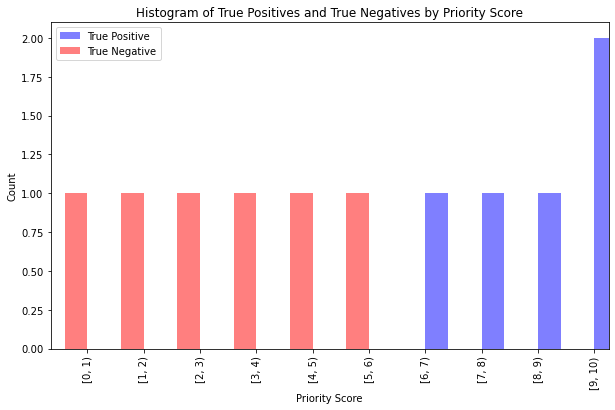

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 仮のデータを作成
data = pd.DataFrame({
    'PriorityScore': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9],
    'LABEL': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
})

# カットオフごとにTPとTNをカウント
bins = range(0, 11) # スコアの範囲を0から10まで
data['bin'] = pd.cut(data['PriorityScore'], bins, right=False)

# TPとTNのカウント
tp_count = data[data['LABEL'] == 1]['bin'].value_counts().sort_index()
tn_count = data[data['LABEL'] == 0]['bin'].value_counts().sort_index()

# ヒストグラムのプロット
fig, ax = plt.subplots(figsize=(10, 6))

tp_count.plot(kind='bar', color='blue', alpha=0.5, position=0, width=0.4, label='True Positive', ax=ax)
tn_count.plot(kind='bar', color='red', alpha=0.5, position=1, width=0.4, label='True Negative', ax=ax)

plt.xlabel('Priority Score')
plt.ylabel('Count')
plt.title('Histogram of True Positives and True Negatives by Priority Score')
plt.legend()
plt.show()

##### My data

In [215]:
mydata_pickle = '../mydata/mydata.final.pickle'
df = pd.read_pickle(mydata_pickle)

In [60]:
def pred_fw(df: pd.DataFrame, cutoff: int) -> pd.DataFrame:
    df[f"FW_PRED_{cutoff}"] = df['FinalScore'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

def pred_maxsplai(df: pd.DataFrame, cutoff: float) -> pd.DataFrame:
    df[f"SpliceAI_PRED_{cutoff}"] = df['maxsplai'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

# confusion matrix

for i in range(0, 11):
    data = pred_fw(data, i)

for i in range(0, 10):
    data = pred_maxsplai(data, i/10)

KeyError: 'FinalScore'

In [61]:
fw_threshold = 0
sa_threshold = 0.5

cm = confusion_matrix(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])
cm2 = confusion_matrix(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])

tn, fp, fn, tp = cm.flatten()
tn2, fp2, fn2, tp2 = cm2.flatten()

print(f"FW: tn={tn}, fp={fp}, fn={fn}, tp={tp}")
print(f"SA: tn={tn2}, fp={fp2}, fn={fn2}, tp={tp2}")
print("")

# fw_score: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), precision_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), recall_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), f1_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])]
# sa_score: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), precision_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), recall_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), f1_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])]

# summary = pd.DataFrame([fw_score, sa_score], columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['FrameWork', 'SpliceAI'])
# print(summary)

fw_accuracy: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_precision: list = [precision_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_recall: list = [recall_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_f1: list = [f1_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]

sa_accuracy: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_precision: list = [precision_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_recall: list = [recall_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_f1: list = [f1_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]


KeyError: 'FW_PRED_0'

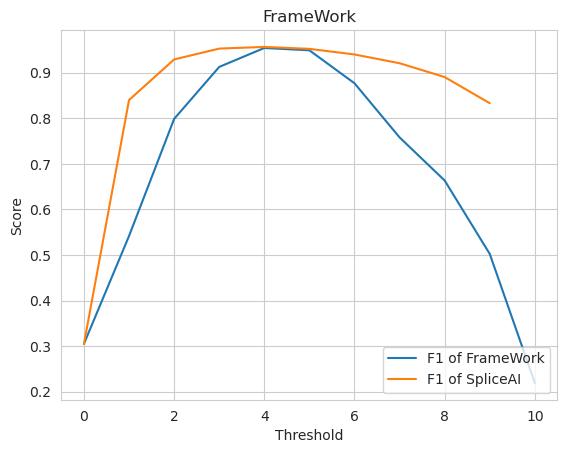

In [104]:

plt.figure()
# plt.plot(fw_accuracy, label='Accuracy of FrameWork')
# plt.plot(fw_precision, label='Precision of FrameWork')
# plt.plot(fw_recall, label='Recall of FrameWork')
plt.plot(fw_f1, label='F1 of FrameWork')

# plt.plot(sa_accuracy, label='Accuracy of SpliceAI')
# plt.plot(sa_precision, label='Precision of SpliceAI')
# plt.plot(sa_recall, label='Recall of SpliceAI')
plt.plot(sa_f1, label='F1 of SpliceAI')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FrameWork')
plt.legend(loc="lower right")
plt.show()

